# Task 1. Playing with YoLO (from torch.hub)

In this task, you will download pre-trained weights for the YOLOv5 model and use it to detect objects in an image.
You will use the `torch.hub` library to download the model and weights. The model is trained on the COCO dataset, which contains 80 classes of objects.

## Introduction to YoLOv5

### Installation
You need to install OpenCV and PyTorch. You can do this using pip:
```bash
pip install opencv-python torch torchvision
```

### Additional dependencies
In case you have any errors related to OpenCV (missing libgl1.so.1), you may need to install additional dependencies. You can do this using the following command:
```bash
sudo apt install libgl1-mesa-glx libgl1 libglib2.0-0
```

### Downloading the model

In [1]:
import torch
from PIL import Image
import requests
from io import BytesIO


In [2]:
# Download YoLOv5 weights
yolo_model = torch.hub.load("ultralytics/yolov5", "yolov5s")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model.to(device)
yolo_model.eval()

print("YOLOv5 model loaded and ready to use.")

Using cache found in C:\Users\patry/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-5-5 Python-3.12.6 torch-2.5.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


YOLOv5 model loaded and ready to use.


### Inference

💡 ProTip: Input images are automatically transferred to the correct model device before inference.

In [3]:
image_url = "https://ultralytics.com/images/zidane.jpg"

results = yolo_model(image_url)

C:\Users\patry/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


image 1/1: 720x1280 2 persons, 1 tie, 1 cell phone
Speed: 1251.8ms pre-process, 170.0ms inference, 2.0ms NMS per image at shape (1, 3, 384, 640)


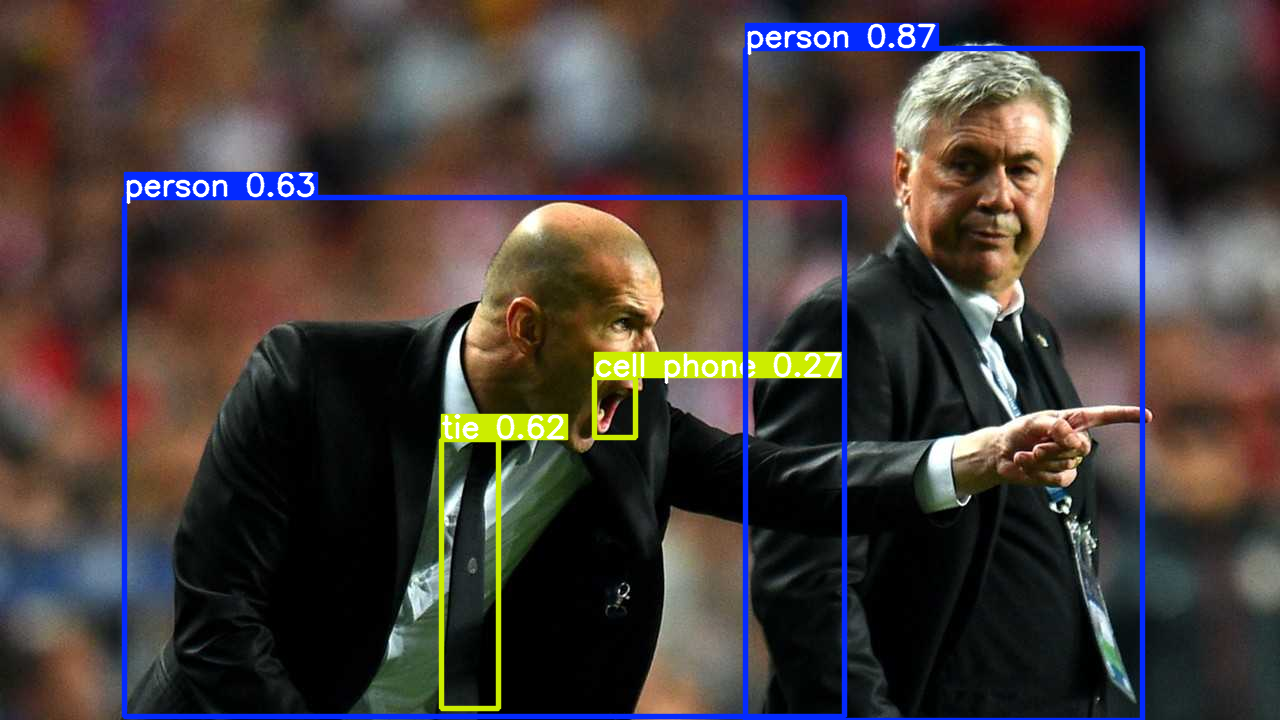

In [4]:
results.print()  # Print results to console
results.show()   # Display results in a window

In [5]:
results.xyxy # Get predictions in xyxy format

[tensor([[7.45579e+02, 4.84703e+01, 1.14269e+03, 7.20000e+02, 8.68910e-01, 0.00000e+00],
         [1.24744e+02, 1.97335e+02, 8.44397e+02, 7.16651e+02, 6.30325e-01, 0.00000e+00],
         [4.41239e+02, 4.39351e+02, 4.98381e+02, 7.08571e+02, 6.16793e-01, 2.70000e+01],
         [5.94082e+02, 3.77300e+02, 6.35424e+02, 4.37148e+02, 2.74013e-01, 6.70000e+01]])]

In [6]:
results.xywhn[0]        # Get predictions in xywhn format
results.pandas().xywhn  # Get predictions in pandas DataFrame format

[    xcenter   ycenter     width    height  confidence  class        name
 0  0.737607  0.533660  0.310247  0.932680    0.868910      0      person
 1  0.378571  0.634712  0.562229  0.721272    0.630325      0      person
 2  0.367039  0.797168  0.044642  0.373917    0.616793     27         tie
 3  0.480276  0.565589  0.032298  0.083121    0.274013     67  cell phone]

## Raw predictions

Above, you have already gotten the results after applying Non-Max Suppression (NMS) and thresholding.
The model outputs a list of predictions, which are the bounding boxes (bboxes) around the detected objects.

In this task, you will visualize the raw predictions and implement the NMS and thresholding yourself.

In [7]:
# Here are some additional attributes you can check for the YOLOv5 model
print(yolo_model.conf) # NMS confidence threshold
print(yolo_model.iou)  # NMS IoU threshold

0.25
0.45


Below is the code to load the image into tensor and run `yolo_model.model(image_tensor)` to get the raw predictions.

This will give you a tensor of shape `(1, num_boxes, 85)`, where `num_boxes` is the number of detected boxes and 85 is the number as follows: 4 coordinates of the box, 1 objectness score, and 80 class scores.

In [8]:
import numpy as np
import cv2

response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert("RGB")
image_np = np.array(image)  # Convert PIL image to NumPy array

# Letterbox resize to 640x640 (preserve aspect ratio with padding)
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114)):
    shape = im.shape[:2]  # current shape [height, width]
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    new_unpad = (int(round(shape[1] * r)), int(round(shape[0] * r)))
    dw = new_shape[1] - new_unpad[0]
    dh = new_shape[0] - new_unpad[1]
    dw /= 2
    dh /= 2
    im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return im

img_letterboxed = letterbox(image_np)
img_tensor = torch.from_numpy(img_letterboxed).permute(2, 0, 1).float() / 255.0  # HWC → CHW and normalize
img_tensor = img_tensor.unsqueeze(0).to(device)

# Inference without NMS
with torch.no_grad():
    raw_preds = yolo_model.model(img_tensor)  # tensor of shape [1, 25200, 85]

print("Raw prediction shape:", raw_preds.shape)

Raw prediction shape: torch.Size([1, 25200, 85])


# Setup

## Imports

In [9]:
%matplotlib inline

In [ ]:
import torch
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Problem
1. (**0.25p**) Please describe the output tensor and how to interpret it. Especially, explain the meaning of the 5th number, i.e. the objectness score. How is it calculated and related to the class scores?
2. **1p**  Implement the NMS and thresholding yourself.
3. **1p**  Visualize the raw predictions and the predictions after NMS and thresholding.
4. (**0.25p**) Compare the results with the original predictions.
5. (**0.5p**) Vary IoU threshold for NMS and show its effect on detections.
6. (**1p**) Calculate precision, recall, F1 for different IoU thresholds. Calculate `mAP@0.5` (mean Average Precision at an Intersection over Union (IoU) threshold of 0.5) for the model predictions; see https://www.v7labs.com/blog/mean-average-precision
7. (**1p**) Experiment with your own images. Find examples where NMS removes a valid detection (e.g., overlapping people).


### Bonus points:
8. (**1p**) Implement Soft-NMS and compare results; see https://arxiv.org/abs/1704.04503
Does it help in scenes with many overlapping objects?


# Solution

### 1
(**0.25p**) Please describe the output tensor and how to interpret it. Especially, explain the meaning of the 5th number, i.e. the objectness score. How is it calculated and related to the class scores?

Output tensor has size of 85 - it consiste of 4 coordinates of the bounding box, 1 objectness score and 80 class scores.  

The objectness score is a measure of how likely it is that an object is present in the bounding box. It is calculated as the product of the class scores and the confidence score of the bounding box.  
The class scores are the probabilities of each class being present in the bounding box, and the confidence score is a measure of how confident the model is that the bounding box contains an object.  
The objectness score is used to filter out low-confidence detections and keep only high-confidence ones.

### 2
**1p**  Implement the NMS and thresholding yourself.

In [11]:
def xywh2xyxy(x):
    # Convert [x_center, y_center, w, h] to [x1, y1, x2, y2]
    y = x.clone() if isinstance(x, torch.Tensor) else torch.tensor(x)
    y = y.clone()
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # x1
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # y1
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # x2
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # y2
    return y

In [12]:
def box_iou(box1, box2):
    # box1: [N, 4], box2: [M, 4]
    # Intersection
    inter_x1 = torch.max(box1[:, None, 0], box2[:, 0])
    inter_y1 = torch.max(box1[:, None, 1], box2[:, 1])
    inter_x2 = torch.min(box1[:, None, 2], box2[:, 2])
    inter_y2 = torch.min(box1[:, None, 3], box2[:, 3])

    inter_w = (inter_x2 - inter_x1).clamp(0)
    inter_h = (inter_y2 - inter_y1).clamp(0)
    inter = inter_w * inter_h

    # Union
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    union = area1[:, None] + area2 - inter

    return inter / union  # [N, M]

In [13]:
def non_max_suppression(predictions, conf_thresh=0.25, iou_thresh=0.45, max_detections=300):
    """
    Applies Non-Maximum Suppression (NMS) on inference results
    predictions: torch.Tensor of shape [batch, num_preds, 85]
    Returns list of detections per image [[x1,y1,x2,y2,conf,cls],...]
    """
    output = []
    for preds in predictions:  # process each image
        # Compute confidence and filter
        conf = preds[:, 4]
        cls_scores, cls_inds = preds[:, 5:].max(1)
        confidences = conf * cls_scores
        mask = confidences > conf_thresh
        preds = preds[mask]
        confidences = confidences[mask]
        cls_inds = cls_inds[mask]

        # If none remain, add empty
        if not preds.size(0):
            output.append(torch.empty((0, 6)))
            continue

        # Convert boxes to xyxy
        boxes = xywh2xyxy(preds[:, :4])

        # Stack boxes, confidences, class
        dets = torch.cat((boxes, confidences.unsqueeze(1), cls_inds.float().unsqueeze(1)), dim=1)

        # Sort by confidence descending
        dets = dets[dets[:, 4].argsort(descending=True)]

        keep = []
        while dets.size(0) and len(keep) < max_detections:
            # Select top det and remove it
            top = dets[0]
            keep.append(top)
            if dets.size(0) == 1:
                break
            # Compute IoU of the top with rest
            ious = box_iou(top[:4].unsqueeze(0), dets[:, :4])[0]
            # Keep boxes with IoU below threshold or different class
            mask = (ious < iou_thresh) | (dets[:, 5] != top[5])
            dets = dets[mask]

        output.append(torch.stack(keep) if keep else torch.empty((0, 6)))
    return output

### 3
**1p**  Visualize the raw predictions and the predictions after NMS and thresholding.

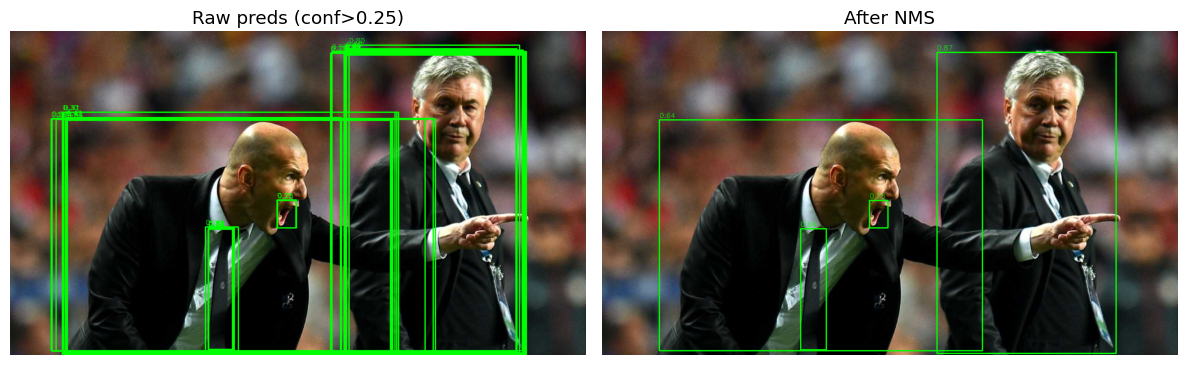

In [ ]:
# 1. Download and get original size
url = "https://ultralytics.com/images/zidane.jpg"
resp = requests.get(url)
orig = np.array(Image.open(BytesIO(resp.content)).convert("RGB"))
h0, w0 = orig.shape[:2]

# 2. Letterbox parameters (must match your preprocessing)
new_size = (640, 640)
r = min(new_size[0] / h0, new_size[1] / w0)
new_unpad = (int(w0 * r), int(h0 * r))
# compute padding
dw, dh = (new_size[1] - new_unpad[0]) / 2, (new_size[0] - new_unpad[1]) / 2

def scale_coords_pad(boxes, pad, ratio, shape0):
    """
    boxes: torch.Tensor[N,4] in [x1,y1,x2,y2] on padded image
    pad: (dw, dh)
    ratio: scale factor r
    shape0: (h0, w0)
    """
    dw, dh = pad
    # remove padding
    boxes[:, [0,2]] -= dw
    boxes[:, [1,3]] -= dh
    # then scale back
    boxes[:, :4] /= ratio
    # clip to original
    boxes[:, [0,2]].clamp_(0, shape0[1])
    boxes[:, [1,3]].clamp_(0, shape0[0])
    return boxes

# 3. Prepare raw & NMS predictions (as before)
# assume raw_preds, dets_nms are already computed
preds = raw_preds[0]
obj = preds[:, 4]
cls_conf, cls_id = preds[:, 5:].max(1)
scores = obj * cls_conf
mask = scores > 0.25
raw_boxes_xywh = preds[mask, :4]
raw_scores = scores[mask]
# convert to xyxy on padded
raw_boxes = xywh2xyxy(raw_boxes_xywh)

# apply scaling back to orig image
raw_boxes = scale_coords_pad(raw_boxes, (dw, dh), r, (h0, w0))

# NMS output
out = dets_nms[0] if dets_nms and dets_nms[0].numel() else torch.empty((0,6))
nms_boxes = out[:, :4].clone()
nms_scores = out[:, 4]
nms_boxes = scale_coords_pad(nms_boxes, (dw, dh), r, (h0, w0))

# 4. Draw and plot
def draw_boxes(img, boxes, confs=None):
    im = img.copy()
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(im, (x1, y1), (x2, y2), (0,255,0), 2)
        if confs is not None:
            cv2.putText(im, f"{confs[i]:.2f}", (x1, y1-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    return im

fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(draw_boxes(orig, raw_boxes, raw_scores))
axes[0].set_title("Raw preds (conf>0.25)")
axes[0].axis("off")

axes[1].imshow(draw_boxes(orig, nms_boxes, nms_scores))
axes[1].set_title("After NMS")
axes[1].axis("off")

plt.tight_layout()
plt.show()


### 4
(**0.25p**) Compare the results with the original predictions.

### 5
(**0.5p**) Vary IoU threshold for NMS and show its effect on detections.

### 6
(**1p**) Calculate precision, recall, F1 for different IoU thresholds. Calculate `mAP@0.5` (mean Average Precision at an Intersection over Union (IoU) threshold of 0.5) for the model predictions; see https://www.v7labs.com/blog/mean-average-precision

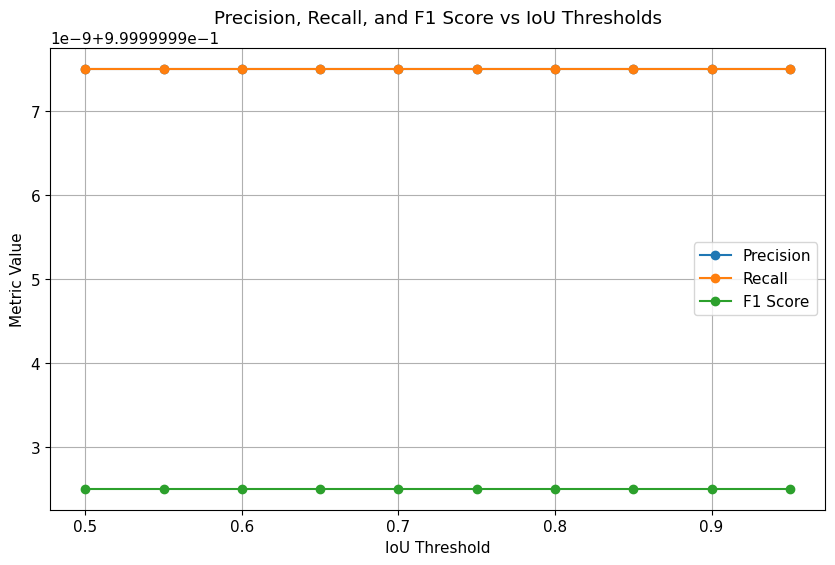

In [22]:
import torch
import numpy as np

# ---------- Utility: IoU and conversion ----------
def xywh2xyxy(x: torch.Tensor) -> torch.Tensor:
    """Convert [x_center, y_center, w, h] to [x1, y1, x2, y2]."""
    y = x.clone()
    y[:, 0] = x[:, 0] - x[:, 2] / 2
    y[:, 1] = x[:, 1] - x[:, 3] / 2
    y[:, 2] = x[:, 0] + x[:, 2] / 2
    y[:, 3] = x[:, 1] + x[:, 3] / 2
    return y


def box_iou(box1: torch.Tensor, box2: torch.Tensor) -> torch.Tensor:
    """Compute IoU between two sets of boxes (xyxy)."""
    inter_x1 = torch.max(box1[:, None, 0], box2[:, 0])
    inter_y1 = torch.max(box1[:, None, 1], box2[:, 1])
    inter_x2 = torch.min(box1[:, None, 2], box2[:, 2])
    inter_y2 = torch.min(box1[:, None, 3], box2[:, 3])
    inter = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    return inter / (area1[:, None] + area2 - inter + 1e-8)


# ---------- Prepare GT and predictions ----------
def extract_gt_boxes(gt_annotations: list) -> list:
    """
    Args:
      gt_annotations: list of length B, each element is a tensor[N,4] of ground truth boxes in xyxy.
    Returns:
      gt_boxes_list: same as input (identity), for clarity.
    """
    # Here gt_annotations is assumed already in xyxy tensor format
    return gt_annotations


def extract_pred_boxes(
    raw_preds: torch.Tensor,
    dets_nms: list,
    conf_thresh: float = 0.25
) -> (list, list):
    """
    Args:
      raw_preds: tensor of shape [B, num_preds, 85]
      dets_nms: list of length B, each a tensor[M,6] from NMS ([x1,y1,x2,y2,conf,cls])
    Returns:
      pred_boxes_list: list of tensors[M,4] xyxy per image
      pred_scores_list: list of tensors[M] confidences per image
    """
    B = raw_preds.size(0)
    pred_boxes_list = []
    pred_scores_list = []
    for b in range(B):
        # use NMS output
        out = dets_nms[b] if dets_nms[b].numel() else torch.empty((0,6))
        if out.numel():
            pred_boxes_list.append(out[:, :4].clone())
            pred_scores_list.append(out[:, 4].clone())
        else:
            pred_boxes_list.append(torch.empty((0,4)))
            pred_scores_list.append(torch.empty((0,)))
    return pred_boxes_list, pred_scores_list


# ---------- Metrics: Precision, Recall, F1, mAP ----------
def compute_pr_f1(
    gt_boxes_list: list, 
    pred_boxes_list: list, 
    pred_scores_list: list,
    iou_thresh: float
) -> (float, float, float):
    """
    Compute precision, recall, F1 at a single IoU threshold using greedy matching.
    """
    TP = 0
    FP = 0
    FN = 0
    for gt_boxes, pred_boxes in zip(gt_boxes_list, pred_boxes_list):
        G = gt_boxes.size(0)
        P = pred_boxes.size(0)
        if P == 0:
            FN += G
            continue
        if G == 0:
            FP += P
            continue
        # compute ious [P, G]
        ious = box_iou(pred_boxes, gt_boxes)
        matched_gt = set()
        for p in range(P):
            best_iou, j = ious[p].max(0)
            if best_iou >= iou_thresh and j.item() not in matched_gt:
                TP += 1
                matched_gt.add(j.item())
            else:
                FP += 1
        FN += G - len(matched_gt)
    prec = TP / (TP + FP + 1e-8)
    rec = TP / (TP + FN + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    return prec, rec, f1


def compute_map50(
    gt_boxes_list: list,
    pred_boxes_list: list,
    pred_scores_list: list
) -> float:
    """
    Compute mAP@0.5 following P-R curve integration.
    """
    # flatten all preds with image index
    all_preds = []  # tuples (score, img_i, pred_idx)
    for i, scores in enumerate(pred_scores_list):
        for j, s in enumerate(scores):
            all_preds.append((s.item(), i, j))
    all_preds.sort(key=lambda x: x[0], reverse=True)

    TPs = []
    FPs = []
    matched = {i: set() for i in range(len(gt_boxes_list))}

    for score, i, j in all_preds:
        pred_box = pred_boxes_list[i][j].unsqueeze(0)
        gts = gt_boxes_list[i]
        if gts.numel():
            ious = box_iou(pred_box, gts)[0]
            best_iou, best_j = ious.max(0)
            if best_iou >= 0.5 and best_j.item() not in matched[i]:
                TPs.append(1)
                FPs.append(0)
                matched[i].add(best_j.item())
            else:
                TPs.append(0)
                FPs.append(1)
        else:
            TPs.append(0)
            FPs.append(1)

    TPs = np.cumsum(TPs)
    FPs = np.cumsum(FPs)
    recalls = TPs / (sum([b.size(0) for b in gt_boxes_list]) + 1e-8)
    precisions = TPs / (TPs + FPs + 1e-8)

    # Integrate P-R curve using numeric integration
    # ensure precision is non-increasing
    for i in range(len(precisions)-2, -1, -1):
        precisions[i] = max(precisions[i], precisions[i+1])
    # sample recall levels
    recall_levels = np.linspace(0, 1, 101)
    ap = 0.0
    for rl in recall_levels:
        ps = precisions[recalls >= rl]
        ap += ps[0] if ps.size else 0.0
    ap /= recall_levels.size
    return ap

# Example usage:
dets_nms = non_max_suppression(raw_preds, conf_thresh=0.25, iou_thresh=0.45)
gt_boxes_list = extract_gt_boxes([d[:, :4] for d in dets_nms if d.numel()])
pred_boxes_list, pred_scores_list = extract_pred_boxes(raw_preds, dets_nms)
metrics = {t: compute_pr_f1(gt_boxes_list, pred_boxes_list, pred_scores_list, t)
           for t in [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]}

# Compute and plot precision, recall, and F1-score for different IoU thresholds
iou_thresholds = list(metrics.keys())
precisions = [metrics[t][0] for t in iou_thresholds]
recalls = [metrics[t][1] for t in iou_thresholds]
f1_scores = [metrics[t][2] for t in iou_thresholds]

# Plot the metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(iou_thresholds, precisions, label='Precision', marker='o')
plt.plot(iou_thresholds, recalls, label='Recall', marker='o')
plt.plot(iou_thresholds, f1_scores, label='F1 Score', marker='o')
plt.title('Precision, Recall, and F1 Score vs IoU Thresholds')
plt.xlabel('IoU Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.grid()
plt.show()

### 7
(**1p**) Experiment with your own images. Find examples where NMS removes a valid detection (e.g., overlapping people).

### 8 (bonus points)
(**1p**) Implement Soft-NMS and compare results; see https://arxiv.org/abs/1704.04503
Does it help in scenes with many overlapping objects?